Here, our goal is to identify whether questions asked on Quora, a quasi-forum website with over 100 million visitors a month, are duplicates of questions that have already been asked. This could be useful, for example, to instantly provide answers to questions that have already been answered. We are tasked with predicting whether a pair of questions are duplicates or not on the basis of training data

In [66]:
import numpy as np
import pandas as pd 
import math
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter
from nltk import word_tokenize

## Data  and Semantic Analysis

In further steps data is analyzed and our training set include 20,000 questions for faster processing.

We are given a minimal number of data fields here, consisting of:<br>
id: Looks like a simple rowID<br>
qid{1, 2}: The unique ID of each question in the pair<br>
question{1, 2}: The actual textual contents of the questions.<br>
is_duplicate: The label that we are trying to predict - whether the two questions are duplicates of each other.<br>

In [67]:
train = pd.read_csv("train.csv", nrows=20000)
print ("Shape of base training File = ", train.shape)

a = 0 
for i in range(a,a+4):
    print(train.question1[i])
    print(train.question2[i])
    print()


Shape of base training File =  (20000, 6)
What is the step by step guide to invest in share market in india?
What is the step by step guide to invest in share market?

What is the story of Kohinoor (Koh-i-Noor) Diamond?
What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?

How can I increase the speed of my internet connection while using a VPN?
How can Internet speed be increased by hacking through DNS?

Why am I mentally very lonely? How can I solve it?
Find the remainder when [math]23^{24}[/math] is divided by 24,23?



Most of the questions appears mostly ones in dataset.The log-histogram obtained below depicts numbers of time question appears on the basis of qid provided in dataset

Total number of question pairs for training: 20000
Duplicate pairs: 37.37%
length of qid1 : 20000
length of qid2 : 20000
length of qids : 40000
Total number of questions in the training data: 37767
Number of questions that appear multiple times: 1806



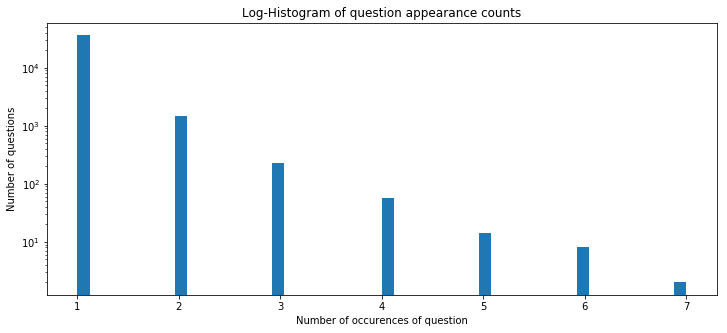

In [68]:
print('Total number of question pairs for training: {}'.format(len(train)))
print('Duplicate pairs: {}%'.format(round(train['is_duplicate'].mean()*100, 2)))
qids = pd.Series(train['qid1'].tolist() + train['qid2'].tolist())
print("length of qid1 :",len(train['qid1'].tolist()))
print("length of qid2 :",len(train['qid2'].tolist()))
print("length of qids :",len(qids))
print('Total number of questions in the training data: {}'.format(len(
    np.unique(qids))))
print('Number of questions that appear multiple times: {}'.format(np.sum(qids.value_counts() > 1)))

plt.figure(figsize=(12, 5))
plt.hist(qids.value_counts(), bins=50)
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of occurences of question')
plt.ylabel('Number of questions')
print()

Next, It shows usage of different punctuation in questions - this may form a basis for some interesting features later on and further pre-processing is carried out on data.

In [69]:
train_qs = pd.Series(train['question1'].tolist() + train['question2'].tolist()).astype(str)
qmarks = np.mean(train_qs.apply(lambda x: '?' in x))
math = np.mean(train_qs.apply(lambda x: '[math]' in x))
fullstop = np.mean(train_qs.apply(lambda x: '.' in x))
capital_first = np.mean(train_qs.apply(lambda x: x[0].isupper()))
capitals = np.mean(train_qs.apply(lambda x: max([y.isupper() for y in x])))
numbers = np.mean(train_qs.apply(lambda x: max([y.isdigit() for y in x])))

print('Questions with question marks: {:.2f}%'.format(qmarks * 100))
print('Questions with [math] tags: {:.2f}%'.format(math * 100))
print('Questions with full stops: {:.2f}%'.format(fullstop * 100))
print('Questions with capitalised first letters: {:.2f}%'.format(capital_first * 100))
print('Questions with capital letters: {:.2f}%'.format(capitals * 100))
print('Questions with numbers: {:.2f}%'.format(numbers * 100))

Questions with question marks: 99.89%
Questions with [math] tags: 0.11%
Questions with full stops: 6.29%
Questions with capitalised first letters: 99.82%
Questions with capital letters: 99.95%
Questions with numbers: 11.82%


## Data Preprocessing

Cleaning consist of getting rid of the less useful parts of text through stopword removal, dealing with capitalization and characters and other details.

1 Stopword Removal:<br>
A majority of the words in a given text are connecting parts of a sentence rather than showing subjects, objects or intent. Word like “the” or “and” cab be removed by comparing text to a list of stopword.The words like “what”, “which” and “how” are not removed form the text  as may have strong signals in determinig the context of questions.<br>
2 Remove punctuation.<br>
3 Correct typos.<br>
4 Change abbreviations to its original terms.<br>
5 Remove comma between numbers.<br>
6 Change special chars to words. And so on.<br>
7 Stemming :<br>
Stemming is a process where words are reduced to a root by removing inflection through dropping unnecessary characters, usually a suffix.The results can be used to identify relationships and commonalities across large datasets.

In [70]:
def cleanup(data):
    data['question1'] = data['question1'].apply(lambda x: x.rstrip('?'))
    data['question2'] = data['question2'].apply(lambda x: x.rstrip('?'))
    # Removing non ASCII chars
    data['question1']=data['question1'].apply(lambda x: x.replace(r'[^\x00-\x7f]',r' '))
    data['question2']=data['question2'].apply(lambda x: x.replace(r'[^\x00-\x7f]',r' ')) 
    return data

In [71]:
# Remove missing values and duplicates from training data
train.drop_duplicates(inplace=True)
train.dropna(inplace=True)
train=cleanup(train)

print("Shape of base training data after cleaning = ", train.shape)
print (train.shape)

Shape of base training data after cleaning =  (20000, 6)
(20000, 6)


In [72]:
stop_words = ['the','a','an','and','but','if','or','because','as','what','which','this','that','these','those','then',
              'just','so','than','such','both','through','about','for','is','of','while','during','to','What','Which',
              'Is','If','While','This']

In [73]:
def remove_reg(text, remove_stop_words=True, stem_words=False):

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9]", " ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"I'm", "I am", text)
    text = re.sub(r" m ", " am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r"e-mail", "email", text)
    text = re.sub(r"\s{2,}", " ", text)
    text = re.sub(r" usa ", " America ", text)
    text = re.sub(r" USA ", " America ", text)
    text = re.sub(r" u s ", " America ", text)
    text = re.sub(r" uk ", " England ", text)
    text = re.sub(r" UK ", " England ", text)
    text = re.sub(r"quora", "Quora", text)
    text = re.sub(r" dms ", "direct messages ", text)  
    text = re.sub(r"kms", " kilometers ", text)
    text = re.sub(r"KMs", " kilometers ", text)
    text = re.sub(r" cs ", " computer science ", text) 
    text = re.sub(r" upvotes ", " up votes ", text)
    text = re.sub(r" iPhone ", " phone ", text)
    text = re.sub(r"\0rs ", " rs ", text) 
    text = re.sub(r"calender", "calendar", text)
    text = re.sub(r"ios", "operating system", text)
    text = re.sub(r"gps", "GPS", text)
    text = re.sub(r"gst", "GST", text)
    text = re.sub(r"the US", "America", text)
    text = re.sub(r" J K ", " JK ", text)
    text = re.sub(r'[^\w\s]','',text)
    
    return text
    

## The TF-IDF Model

The two methods below are parts of implementation to the idf (inverse document frequency).<br>

The first function returns the count of sentences/documents/paragraphs where the word is present.

The second, idf method returns the value of the log.

In [74]:
def n_containing(qlist, word):
    return float(qlist[word])

In [75]:
def tf(question, word):
    if word not in question:
        return 0
    count = dict(Counter(question))
    q_len = len(question)
    return (float(count[word]) / float(q_len))

In [76]:
def idf(qlist, word):
    val = float(len(qlist.keys())) / (1.0 + n_containing(qlist, word))
    return np.log(val)

The tfidf function is used to return a number, of which I would be making a vector, of the two statements (I won't usually give a single word, the above is a utility function I used from an old implementation).

For the function below, v1 and v2 are two vectors (list of numbers in this case) of the same dimensions. Function returns the cosine distance between those which is the ratio of the dot product of the vectors.

In [77]:
def tfidf(question, qlist, word):
    return tf(question, word) * idf(qlist, word)

In [78]:
def cosine(v1, v2):
    v1 = np.array(v1)
    v2 = np.array(v2)

    return np.dot(v1, v2) / (np.sqrt(np.sum(v1**2)) * np.sqrt(np.sum(v2**2)))

In [79]:
import re
import gensim
from gensim import corpora
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *

words = re.compile(r"\w+",re.I)
stopwords = set(stopwords.words("english"))
stemmer = PorterStemmer()

train_qs1 = train[['id', 'question1', 'question2', 'is_duplicate']]

qlist = []
for row in train_qs1.itertuples():
    try:
        if len(str(row[2])) > 10:
            q1 = ([remove_reg((w)) for w in word_tokenize(row[2].lower()) if w not in stop_words])
        if len(str(row[3])) > 10:
            q2 = ([remove_reg((w)) for w in word_tokenize(row[3].lower()) if w not in stop_words])
        qlist += q1 + q2
    except TypeError:
        pass

# print len(qlist)
qlist = dict(Counter(qlist))
#print(qlist)

In [80]:
from sklearn.model_selection import train_test_split

train,test = train_test_split(train, test_size = 0.1)
print (train.shape)
print (test.shape)

(18000, 6)
(2000, 6)


## Predictions

1 Fitting the tf-idf model to the test and train data.<br> 
2 Creating y_pred for binary evaluation of test data on the basis of cosine similarity of tf-idf vector and setting a threshold on the cosine value <br>
3 The accuracy of the model is calculated using sklearn library

In [81]:
test_qs = test[['id', 'question1', 'question2', 'is_duplicate']]  
def predict(test):
    y_output=[]
    for row in test_qs.itertuples():
        if len(str(row[2])) > 10 and len(str(row[3])) > 10:
#             wordvec1 = word_tokenize(row[2].lower())
#             wordvec2 = word_tokenize(row[3].lower())
#             words = wordvec1 + wordvec2
#             words = list(set([word for word in words if word != '?']))

            wordvec1 = ([remove_reg((w)) for w in word_tokenize(row[2].lower()) if w not in stopwords])
            wordvec2 = ([remove_reg((w)) for w in word_tokenize(row[3].lower()) if w not in stopwords])
            ques1=" "
            ques2=" "
            ques1=ques1.join(wordvec1)
            ques2=ques2.join(wordvec2)
#           print(ques1)
#           print(ques2)
            words = wordvec1 + wordvec2
            words = list(set([word for word in words if word != '?']))

            # print words

            vec1 = []
            vec2 = []
            for word in words:
                vec1.append(tfidf(wordvec1, qlist, word))
                vec2.append(tfidf(wordvec2, qlist, word))
            
            y_output.append(cosine(vec1,vec2))
#           print(cosine(vec1,vec2))
        else:
#           print(0)
            y_output.append(0)
    return y_output

In [82]:
y_pred = predict(test)

In [83]:
y=[]
for row in test.itertuples():
    y.append(row[6])

In [84]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

score=[]
level=0.1
for i in range(0,55):
    y_out=[]
    for k in y_pred:
        if k>level:
            y_out.append(1)
        else:
            y_out.append(0)
    level=level+.01
    mat=confusion_matrix(y, y_out)
    score.append(f1_score(y,y_out))
    
print(score)

[0.6119823080016084, 0.6133979015334948, 0.6143896523848019, 0.6170731707317073, 0.6185230518155854, 0.6185989348627612, 0.6190476190476191, 0.621487603305785, 0.6224066390041493, 0.6267782426778241, 0.6318009278785323, 0.6329651656754461, 0.6358579375267437, 0.6371071889797676, 0.6409366869037294, 0.6418889374726716, 0.6434859154929576, 0.6441881100266194, 0.6436884512085944, 0.6453068592057762, 0.6475148198814409, 0.6474094452086199, 0.6472222222222223, 0.6485727655591952, 0.648956356736243, 0.648545541249404, 0.6490638502160346, 0.6494644595910419, 0.6459871984244214, 0.6444554947787171, 0.6437246963562753, 0.6424923391215526, 0.6399176954732511, 0.6400828586224755, 0.639832723470988, 0.6313559322033898, 0.6262083780880774, 0.623574144486692, 0.6226622662266227, 0.6177777777777778, 0.615990990990991, 0.611333714939897, 0.6083916083916084, 0.6020106445890006, 0.5997610513739546, 0.5991510006064281, 0.5906288532675709, 0.5845771144278606, 0.5808080808080809, 0.582375478927203, 0.57956

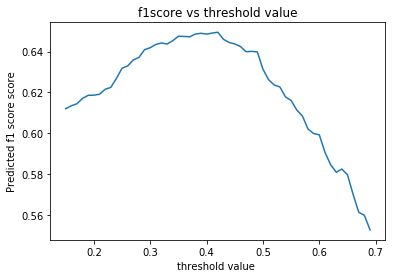

In [85]:
l=[]
thr=0.15
for i in range(0,55):
    l.append(thr)
    thr=thr+.01
plt.plot(l,score)
plt.xlabel('threshold value ')
plt.ylabel('Predicted f1 score score')
plt.title('f1score vs threshold value')
plt.show()

In [86]:
print("maximum accuracy obtained id : ",max(score))
idx=score.index(max(score))
print("maximum accuracy obtained at threshold : ",idx)

maximum accuracy obtained id :  0.6494644595910419
maximum accuracy obtained at threshold :  27


In [87]:
y_out=[]
thr=0.1+(idx*0.01)
for k in y_pred:
    if k>=thr:
        y_out.append(1)
    else:
        y_out.append(0)
confusion_matrix(y, y_out)

array([[613, 619],
       [101, 667]])